In [5]:
%pylab inline
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/home/mikhail/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [411]:
from sklearn.feature_selection import SelectKBest, f_regression


In [374]:
wages = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [375]:
wages.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


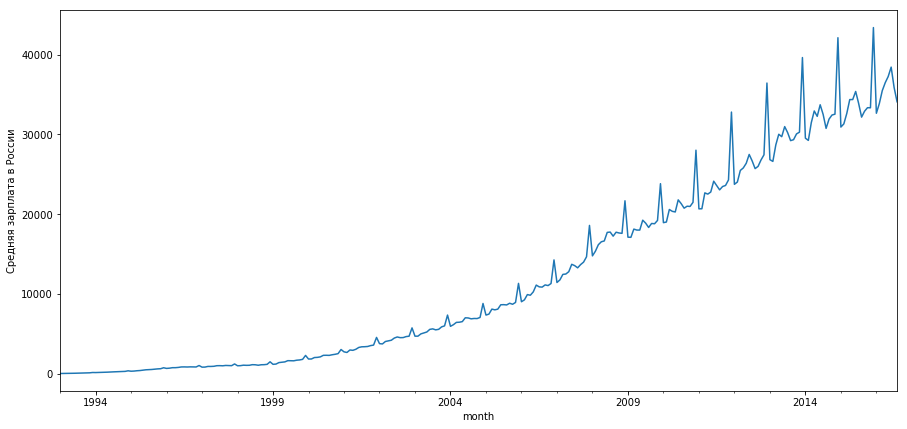

In [376]:
plt.figure(figsize(15,7))
wages.WAG_C_M.plot()
plt.ylabel('Средняя зарплата в России');


На графике ярко выражены тренд и мультипликативная сезонность.

## Преобразуем временной ряд

In [377]:
wages['WAG_C_M'], lmbda = stats.boxcox(wages.WAG_C_M)


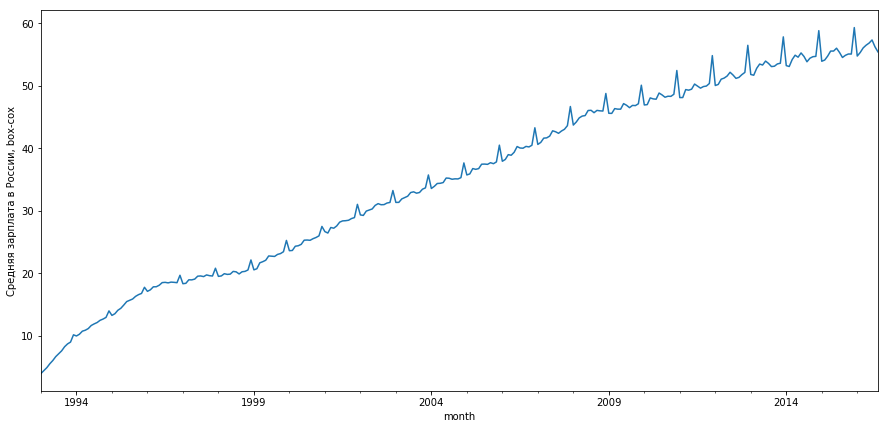

In [378]:
plt.figure(figsize(15,7))
wages.WAG_C_M.plot()
plt.ylabel('Средняя зарплата в России, box-cox');


Тренд почти линейный. Сезонность аддитивная.

## Генерирование признаков

Для начала создадим фичи по каждому месяцу.

In [379]:
months = ['m{}'.format(i) for i in range(1, 13)]

In [402]:
wages['date'] = wages.index
wages['time'] = [i + 1 for i in range(len(wages))]
for month in months:
    wages[month] = wages['date'].apply(lambda x: 1 if int(x.month) == int(month[1:]) else 0)

In [403]:
wages.head()

,WAG_C_M,date,time,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
month,,,,,,,,,,,,,,,
1993-01-01,3.990393,1993-01-01,1,1,0,0,0,0,0,0,0,0,0,0,0
1993-02-01,4.458758,1993-02-01,2,0,1,0,0,0,0,0,0,0,0,0,0
1993-03-01,4.931635,1993-03-01,3,0,0,1,0,0,0,0,0,0,0,0,0
1993-04-01,5.549430,1993-04-01,4,0,0,0,1,0,0,0,0,0,0,0,0
1993-05-01,6.063406,1993-05-01,5,0,0,0,0,1,0,0,0,0,0,0,0


In [382]:
wages.groupby(by=months[8:10])['WAG_C_M'].describe()

count       mean        std       min        25%        50%  \
m9 m10                                                                
0  0    238.0  35.116719  15.094680  3.990393  20.772403  35.759792   
   1     23.0  34.844386  14.628603  8.726834  21.756164  35.126249   
1  0     23.0  34.694763  14.634729  8.275619  21.658273  35.141072   

              75%        max  
m9 m10                        
0  0    48.768088  59.343998  
   1    47.600165  55.115102  
1  0    47.623825  54.906745

## Построим модель на таких данных

Оставим на тесте последний 2 года наблюдений

In [404]:
X_test = wages[-24:][months]; X_test['t'] = wages['time']
y_test = wages[-24:]['WAG_C_M']
X_train = wages[:-24][months]; X_train['t'] = wages['time']
y_train = wages[:-24]['WAG_C_M']

In [405]:
from sklearn.linear_model import LinearRegression

In [406]:
lr = LinearRegression(n_jobs=-1)

In [407]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

Посчитаем R^2 и построим график предсказания

In [408]:
lr.score(X_test, y_test)

-9.5165799663104984

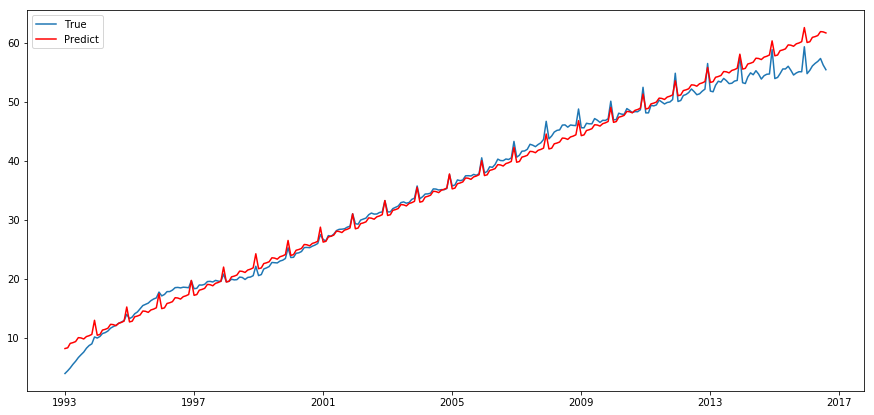

In [409]:
plt.plot(wages.index, wages.WAG_C_M, label='True')
plt.plot(wages.index, np.concatenate((lr.predict(X_train), lr.predict(X_test))), 'r', label='Predict');
plt.legend();

Видим, что наша модель смогла определить пики и спады, но часто ошибается с величиной зарплаты

### Выберем только 5 признаков(4 месяцев и порядок)

Выбирать будем с помощью F-теста

In [482]:
sel = SelectKBest(f_regression, k=5)
sel.fit(X_train, y_train)


SelectKBest(k=5, score_func=<function f_regression at 0x7f7ad68820d0>)

In [483]:
X_test_transform = sel.transform(X_test)
X_train_transofrm = sel.transform(X_train)

-9.52395022901


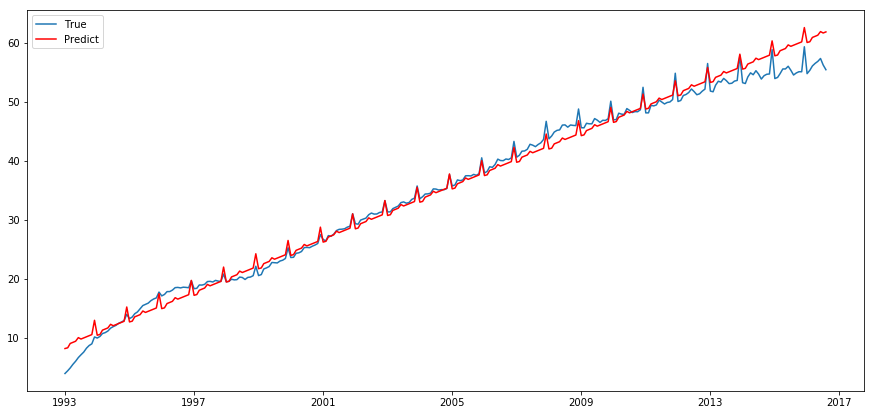

In [485]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train_transofrm, y_train)
print(lr.score(X_test_transform, y_test))
plt.plot(wages.index, wages.WAG_C_M, label='True')
plt.plot(wages.index, np.concatenate((lr.predict(X_train_transofrm), lr.predict(X_test_transform))), 'r', label='Predict');
plt.legend();

Как видим, не помогло